In [49]:

import yaml
import os

from numpy import *
import luxeics
import h5py

from scipy.interpolate import interp2d,RectBivariateSpline

import matplotlib.pyplot as plt

import luxeics


def Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path):
    
    
    Area=pi*spotsize**2

    
    selector= sqrt((xoffset+X1)**2+(yoffset+X2)**2) < spotsize


#     print ( f'IP-laser spot size: {spotsize:.2f} micron')
#     print ( f'baseline          : {baseline/1e6:.2f} metres')
#     print ('-'*42)

#     print (f'photons in spot')
#     print (f'macrophoton weight               : {amax(W):.4g}')
    
#     print ( 'macrophotons, finite source size :',sum( selector) )
    
#     print ( 'photon weight, finite source size:',sum(W[selector ] ) )
    
    
    P=sum(W[selector ] )/Area
    
#     print ( f'Photon density, finite source size:',P)
    
#     print (' ######################################### '  )
#     print ('                           '  )
#     plt.figure(figsize=(14,6))

    

#     ax1=plt.subplot(122,aspect=1)

#     # plot(X1+xoffset, X2+yoffset, color='m', marker=',',lw=0);





#     plt.scatter(X1+xoffset, X2+yoffset, color='m', marker='.',lw=0,s=W);

#     plt.xlim(-2*spotsize,2*spotsize)
#     plt.ylim(-2*spotsize,2*spotsize)
    
#     plt.xlabel(r'$x$ (micron)')
#     plt.ylabel(r'$y$ (micron)');
#     plt.title(f'Finite source size, Photon density:{round(P,2)} micron^(-2)')

    
#     ax1.add_patch(plt.Circle((0,0),spotsize,color='C0',fill=False))


#     plt.suptitle(f' sigmaT :{sigmaT} micron ; spotsize:{spotsize} micron')
#     plt.savefig(f'{path}\photon_spectrum_at_focus_{sigmaT}_{spotsize}.png',dpi=200)
    
    return(P)
                                      
    
                                   
def run(spotsize,input_filename,path):
    

    
    
    with h5py.File(input_filename + '.h5' ,'r') as ff:
    #     omega      = ff['final-state/spectrum/omega'][:]/1e9
    #     theta      = ff['final-state/spectrum/theta'][:]*1e6
    #     spectrum   = ff['final-state/spectrum/spectrum'][:]

        K0,K1,K2,K3  = ff['final-state/photon/momentum'][:].T
        X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
        W            = ff['final-state/photon/weight'  ][:]

        P0,P1,P2,P3  = ff['final-state/electron/momentum'][:].T
    #     X0,X1,X2,X3  = ff['final-state/photon/position'][:].T
    #     We            = ff['final-state/photon/weight'  ][:]
    with open( input_filename + '.yml', 'r' ) as stream:
        input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        mode             = input_dict['control']['mode']


        beam_charge      = float( input_dict['beam']['beam_charge'])
        number_electrons = int( beam_charge / 1.60217653e-19)

    #     sampling         = input_dict['control']['sampling']
        sampling = mode

        w0               = float(input_dict['laser']['w0'])
        omega0           = float(input_dict['laser']['omega0'])
        gamma            = float(input_dict['beam']['gamma'])
        Xr               = 4*gamma*omega0/511*10**(-3)
        energyspread     = float(input_dict['beam']['energyspread'])
        sigmaT   = float(input_dict['beam']['sigmaT'])
#     print (f'beam charge                              : {beam_charge*1e12:.24} pC')
#     print (f'number of beam electrons                 : {number_electrons:.3e}')
#     print ('-'*42)
#     print (f'{sampling} sampling:')
#     print (f'max  single photon weight                : {amax(W):.4g}')
#     print (f'mean single photon weight                : {mean(W):.4g}')
#     print (f'total photon weight                      : {sum(W):.4g}')
#     print (f'total photon weight per incident electron: {sum(W)/number_electrons:.4g}')
#     print (f'total macro photon number                : {len(W)}')
#     print ('-'*42)
#     print(f' Frequency (Laser) :  {omega0}'  )
#     print(f'Recoil Factor:{Xr}')
#     print (' ######################################### '  )
#     print ('                           '  )
    baseline = 7.5e6

    thetax=K1/K3
    thetay=K2/K3

     

    xoffset = thetax * baseline
    yoffset = thetay * baseline
    
    Pd=Photon_density(xoffset,yoffset,X1,X2,baseline,spotsize,sigmaT,W,path)
    
    
    E=sum(P0)
    
    return(Pd,E)

In [50]:


input_filename = "New"
n=10
sigma=zeros(n)
r=10 #Number of runs
Pd = ones((n,2,r))
spotsize1=3
spotsize2=10
directory = "Energy_Conserved_Run1(mit_error)"
parent_dir = f"{os. getcwd()}\Photon_Density"
path = os.path.join(parent_dir, directory)
os.mkdir(path)



'''

Energy= I0 * pi* (w0 **2)* T_fwhm
I0= (omega*m*a0)**2/(8*pi*alpha)

a0*w0= constant

'''
Energy = zeros((n,r))
with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            w0=input_dict['laser']['w0']
            a0=input_dict['laser']['a0']
            constant=w0*a0  # from energy Conservation 

            
            
                    
for j in range(r):
    for i in range(n):
        with open( input_filename+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)
            sigma1= 5+i*5

            input_dict['beam']['sigmaT']=sigma1
            input_dict['control']['name']=f'{path}\SigmaT{sigma1}'
            input_dict['laser']['w0']=sigma1
            input_dict['laser']['a0']=constant/sigma1
            ###Comment the previous line to just to do a parameter run in sigmaT
            input_filename1 = f'SigmaT{sigma1}'


        with open(      f'{path}\SigmaT{sigma1}'+'.yml', 'w') as file:
            documents = yaml.dump(input_dict, file)

        # import matplotlib.pyplot as plt

        sigma[i]=sigma1


        with open( f'{path}\SigmaT{sigma1}'+'.yml', 'r' ) as stream:
            input_dict = yaml.load(stream, Loader=yaml.SafeLoader)

        #print (input_dict)



        luxeics.main_program( f'{path}\SigmaT{sigma1}'+'.yml' )

        Pd[i,0,j],Energy[i,j]=run(spotsize1,f'{path}\SigmaT{sigma1}',path)
        Pd[i,1,j],Energy[i,j]=run(spotsize2,f'{path}\SigmaT{sigma1}',path)


>>> mode == full
[10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000, 10000000] 100000000 100000000
 >> number_electrons   = 624150947
 >> sample_electrons   = 100000000
 >> electron weight    = 6.242
 >> MC sampling
  > batch 0 : 10000000 macroelectrons
   base photon weight : 190.2749255781099
   number photons     : 3510
   total photon number: 3510
  > batch 1 : 10000000 macroelectrons


KeyboardInterrupt: 

In [ ]:
print(sigma)
print(Energy*10**(-9))

In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel(r'Photon Density [microns^(-2)]')
# plt.legend()
# plt.title('Zero Source Size')
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Zero.png',dpi=200)

In [ ]:
# plt.plot(sigma,Pd[:,0],label=f'{spotsize1} microns')
# plt.plot(sigma,Pd[:,1],label=f'{spotsize2} microns')
# plt.xlabel('SigmaT [microns]')
# plt.ylabel('Photon Density [microns^(-2)]')
# plt.title('Finite Source Size')
# plt.legend()
# plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Finite.png',dpi=200)

In [45]:
import numpy as np
Pd_Mean=np.ones((n,2))

Pd_STD=np.ones((n,2))
for i in range(n):

    Pd_Mean[i,0]=np.mean(Pd[i,0,:])
    Pd_STD[i,0]=np.std(Pd[i,0,:])
    Pd_Mean[i,1]=np.mean(Pd[i,1,:])
    Pd_STD[i,1]=np.std(Pd[i,1,:])

In [46]:
print(np.shape(Pd))

(10, 2, 10)


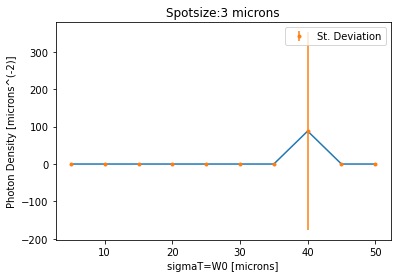

In [47]:
plt.plot(sigma,Pd_Mean[:,0])
plt.errorbar(sigma,Pd_Mean[:,0],Pd_STD[:,0], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize1} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize1}_Finite.png',dpi=200)

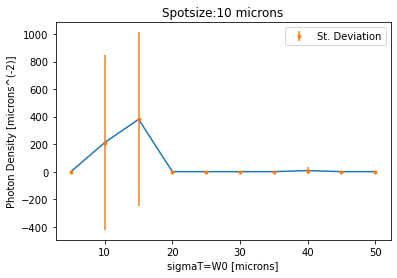

In [48]:
plt.plot(sigma,Pd_Mean[:,1])
plt.errorbar(sigma,Pd_Mean[:,1],Pd_STD[:,1], linestyle='None', marker='.',label='St. Deviation')
plt.xlabel('sigmaT=W0 [microns]')
plt.ylabel('Photon Density [microns^(-2)]')
plt.title(f'Spotsize:{spotsize2} microns')
plt.legend()
plt.savefig(f'{path}\PhotonDensity_vs_sigmaT_Spotsize{spotsize2}_Finite.png',dpi=200)

In [ ]:
# import pandas as pd
# import numpy as np
# import os
# Data=np.zeros((n,3))
# Data[:,0]=sigma
# Data[:,1]=Pd[:,0]
# Data[:,2]=Pd[:,1]
# df=pd.DataFrame(Data)

# List=["Sigma","3 microns              ","10 microns"]
# df.to_csv(f'{path}\Photon_Density.txt',header=List , index=None, sep="\t", mode='w')



# print(df)

In [ ]:
'''
Saving the Data
'''


import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,0,0:r]
df=pd.DataFrame(Data)

List=["SigmaT+W0","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize1}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

In [ ]:
import pandas as pd
import numpy as np
import os
Data=np.zeros((n,r+1))
Data[:,0]=sigma
Data[:,1:r+1]=Pd[:,1,0:r]
df=pd.DataFrame(Data)

List=["SigmaT+W0","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density ","Photon Density "]
df.to_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=List , index=None, sep="\t", mode='w')



print(df)

In [ ]:
'''
Reading the text files
The final array p does not contain the Header files

'''
print(pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=None , sep="\t"))

r=pd.read_csv(f'{path}\Photon_Density_Spotsize{spotsize2}.txt',header=0 , sep="\t")
p=pd.DataFrame.to_numpy(r)
